# Reddit Posts Sentiment Analysis

We will be looking at 2 different techiniques of doing sentiment analysis:
1. __VADER__ (Valence Aware Dictionary and sEntiment Reasoner) - Bag of words approach
2. __Roberta__ - Pretrained Transformer Model
3. __Abstract Based Sentiment Analysis__

In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

C:\Users\aryan\AppData\Local\Temp\ipykernel_26964\1921943495.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Read csv
df = pd.read_csv(r"D:\Projects\Reddit-Data-Pipeline\data\output\reddit_20240220.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            3798 non-null   object 
 1   subreddit     3798 non-null   object 
 2   title         3798 non-null   object 
 3   score         3798 non-null   int64  
 4   num_comments  3798 non-null   int64  
 5   author        3611 non-null   object 
 6   created_utc   3798 non-null   object 
 7   upvote_ratio  3798 non-null   float64
dtypes: float64(1), int64(2), object(5)
memory usage: 237.5+ KB


In [4]:
df.head()

,id,subreddit,title,score,num_comments,author,created_utc,upvote_ratio
0,jptq5n,politics,Megathread: Joe Biden Projected to Defeat Pres...,214312,81613,PoliticsModeratorBot,2020-11-07 16:28:04,0.88
1,84aiy6,science,Physicist Stephen Hawking dies aged 76,199298,3830,ScienceModerator,2018-03-14 04:06:14,0.92
2,krntg6,politics,Mitch McConnell Will Lose Control Of The Senat...,156745,10140,klawdz,2021-01-06 13:25:44,0.92
3,bblu6v,science,The first picture of a black hole opens a new ...,155298,5512,Science_News,2019-04-10 13:11:37,0.95
4,ecm1zg,politics,Megathread: House Votes to Impeach President D...,147732,50885,PoliticsModeratorBot,2019-12-19 01:36:13,0.89


In [15]:
df['id'].is_unique

True

In [16]:
df['subreddit'].is_unique

False

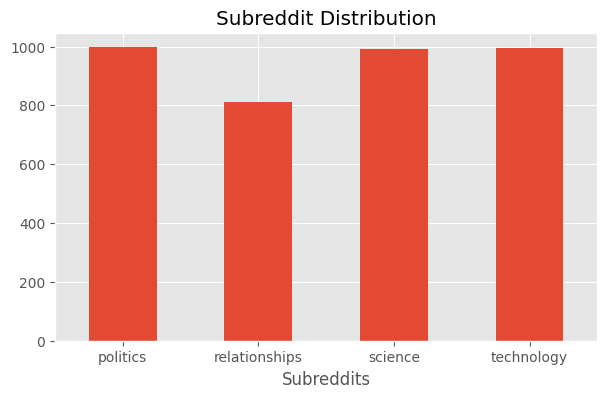

In [5]:
ax = df['subreddit'].value_counts().sort_index().plot(kind = 'bar',
                                                      title = 'Subreddit Distribution',
                                                      figsize=(7,4))

ax.set_xlabel('Subreddits')
plt.xticks(rotation=0)
plt.show()

In [6]:
sample = df['title'][23]
sample

'House charges Donald Trump with impeachment for "inciting an insurrection"'

## 1. Vader (Valence Aware Dictionary and sEntiment Reasoner)

Vader is a popular sentiment analysis tool in Python that provides a pre-trained model for sentiment analysis. It is a rule-based sentiment analysis tool that is specifically designed for analyzing social media texts.

Vader uses a dictionary of words and rules to determine the sentiment of a piece of text. It uses a valence score for each word to determine its positivity or negativity. The valence score ranges from -4 to +4, with -4 being the most negative and +4 being the most positive. Vader also takes into account the intensity of the sentiment, which can be determined by capitalization and punctuation.

The __SentimentIntensityAnalyzer__ class provides a method called `polarity_scores()` that takes a piece of text as input and returns a dictionary containing the sentiment scores for the text. The dictionary contains four keys: `neg`, `neu`, `pos`, and `compound`.

- neg: the negative sentiment score (between 0 and 1)
- neu: the neutral sentiment score (between 0 and 1)
- pos: the positive sentiment score (between 0 and 1)
- compound: the overall sentiment score (between -1 and 1)

In [7]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\aryan\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [8]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

vader = SentimentIntensityAnalyzer()

In [9]:
vader.polarity_scores("i love to play Football!")

{'neg': 0.0, 'neu': 0.225, 'pos': 0.775, 'compound': 0.784}

In [10]:
vader.polarity_scores("I do not like this!")

{'neg': 0.445, 'neu': 0.555, 'pos': 0.0, 'compound': -0.3404}

In [11]:
vader.polarity_scores(sample)

{'neg': 0.189, 'neu': 0.811, 'pos': 0.0, 'compound': -0.2732}

In [13]:
# Running the polarity score on the dataset
results = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['title']
    my_id = row['id']
    results[my_id] = vader.polarity_scores(text)

  0%|          | 0/3798 [00:00<?, ?it/s]

In [26]:
vaders_result = pd.DataFrame(results).T
vaders_result = vaders_result.reset_index().rename(columns={'index': 'id'})
vaders_result = vaders_result.merge(df, how='left', on='id')

In [27]:
vaders_result.head()

,id,neg,neu,pos,compound,subreddit,title,score,num_comments,author,created_utc,upvote_ratio
0,jptq5n,0.144,0.673,0.183,0.2023,politics,Megathread: Joe Biden Projected to Defeat Pres...,214312,81613,PoliticsModeratorBot,2020-11-07 16:28:04,0.88
1,84aiy6,0.000,1.000,0.000,0.0000,science,Physicist Stephen Hawking dies aged 76,199298,3830,ScienceModerator,2018-03-14 04:06:14,0.92
2,krntg6,0.162,0.838,0.000,-0.4019,politics,Mitch McConnell Will Lose Control Of The Senat...,156745,10140,klawdz,2021-01-06 13:25:44,0.92
3,bblu6v,0.104,0.896,0.000,-0.4215,science,The first picture of a black hole opens a new ...,155298,5512,Science_News,2019-04-10 13:11:37,0.95
4,ecm1zg,0.000,1.000,0.000,0.0000,politics,Megathread: House Votes to Impeach President D...,147732,50885,PoliticsModeratorBot,2019-12-19 01:36:13,0.89
